## This script should build a plot for biomass composition

In [2]:
# imports
import cobra
import yaml
import pandas as pd

import sys # append path

sys.path.append('../scripts/')
import helperFunction as hf

# config
config_name = 'model_config'
config_path = f'../config/{config_name}.yaml'

# load config
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [3]:
# plot again the corrected models against each other

iYali4_model_path = config['models']['yli4_corr']
iYali4_model = cobra.io.read_sbml_model(iYali4_model_path)

## add biomass
iYali4_model.objective = 'biomass_C'

No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


In [4]:
yliMK735_model = cobra.io.read_sbml_model(config['models']['yliMK735'])

# add objective function
yliMK735_model.objective = 'biomass_C'

No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


### Wie ist die biomasse beim besten Modell (iMK735) verteilt?

In [5]:
# default flux (10 mmol/h D-glucose) 1.054 gDW/h (growht rate)
yliMK735_model.summary()

# # Does a change of the growth condition changes the biomass reaction? - Nein, aber die Fluxes der metabolites
# EX_glc = yliMK735_model.reactions.get_by_id('EX_glc(e)')
# EX_glc.bounds = (-30, 1000)
# yliMK735_model.summary()


Metabolite,Reaction,Flux,C-Number,C-Flux
glc_D[e],EX_glc(e),10,6,100.00%
nh4[e],EX_nh4(e),7.187,0,0.00%
o2[e],EX_o2(e),18.37,0,0.00%
pi[e],EX_pi(e),0.3563,0,0.00%
so4[e],EX_so4(e),0.07153,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2[e],EX_co2(e),-20.04,1,100.00%
h[e],EX_h(e),-6.983,0,0.00%
h2o[e],EX_h2o(e),-34.59,0,0.00%


In [6]:
# summary of the biomass_C reaction
yliMK735_model.reactions.biomass_C.summary()

## Hinzufügen von biomass metabolite Sinnvoll? - Nein
# 0.943397 13BDglcn[c] + 0.567939 ala_L[c] + 0.055401 amp[c] + 0.125563 arg_L[c] + 0.186498 asn_L[c] + 0.186531 asp_L[c] + 23.09 atp[c] + 0.868358 chitin[c] + 0.05721 cmp[c] + 0.003632 cys_L[c] + 0.01007 damp[c] + 0.010436 dcmp[c] + 0.009226 dgmp[c] + 0.010353 dtmp[c] + 0.035251 ergst[c] + 0.243866 gln_L[c] + 0.243904 glu_L[c] + 0.509943 gly[c] + 0.050871 gmp[c] + 23.09 h2o[c] + 0.053881 his_L[c] + 0.090566 ile_L[c] + 0.19455 leu_L[c] + 0.275005 lys_L[c] + 0.235849 mannan[c] + 0.044232 met_L[c] + 5.8e-05 pa_SC[c] + 0.000346 pc_SC[c] + 0.000237 pe_SC[c] + 0.082571 phe_L[c] + 0.206372 pro_L[c] + 3.5e-05 ps_SC[c] + 7.5e-05 ptd1ino_SC[c] + 0.284699 ser_L[c] + 0.02 so4[c] + 0.210543 thr_L[c] + 0.00686 tre[c] + 0.000234 triglyc_SC[c] + 0.002154 trp_L[c] + 0.041282 tyr_L[c] + 0.059363 ump[c] + 0.172773 val_L[c] + 0.003029 zymst[c] --> 23.09 adp[c] + 23.09 h[c] + 23.09 pi[c]
# 0.943397 13BDglcn[c] + 0.567939 ala_L[c] + 0.055401 amp[c] + 0.125563 arg_L[c] + 0.186498 asn_L[c] + 0.186531 asp_L[c] + 23.09 atp[c] + 0.868358 chitin[c] + 0.05721 cmp[c] + 0.003632 cys_L[c] + 0.01007 damp[c] + 0.010436 dcmp[c] + 0.009226 dgmp[c] + 0.010353 dtmp[c] + 0.035251 ergst[c] + 0.243866 gln_L[c] + 0.243904 glu_L[c] + 0.509943 gly[c] + 0.050871 gmp[c] + 23.09 h2o[c] + 0.053881 his_L[c] + 0.090566 ile_L[c] + 0.19455 leu_L[c] + 0.275005 lys_L[c] + 0.235849 mannan[c] + 0.044232 met_L[c] + 5.8e-05 pa_SC[c] + 0.000346 pc_SC[c] + 0.000237 pe_SC[c] + 0.082571 phe_L[c] + 0.206372 pro_L[c] + 3.5e-05 ps_SC[c] + 7.5e-05 ptd1ino_SC[c] + 0.284699 ser_L[c] + 0.02 so4[c] + 0.210543 thr_L[c] + 0.00686 tre[c] + 0.000234 triglyc_SC[c] + 0.002154 trp_L[c] + 0.041282 tyr_L[c] + 0.059363 ump[c] + 0.172773 val_L[c] + 0.003029 zymst[c] --> 23.09 adp[c] + 23.09 h[c] + 23.09 pi[c]

#### Way to iterate over the biomass reaction metabolites and find their production and consumption reactions + values

In [7]:
biomass_rxn = yliMK735_model.reactions.get_by_id('biomass_C')
# print(type(biomass_rxn.metabolites))
#### example with glycan:
# BDglcn = list(biomass_rxn.metabolites.keys())[0]
# glycan_summary = BDglcn.summary()
# glycan_summary

# # loop over metabolites in biomass reaction and print all fluxes
biomass_met = list(biomass_rxn.metabolites.keys())
biomass_met_factor = list(biomass_rxn.metabolites.values())
biomass_fluxes = [] # (met_id, metabolite_factor_biomass, flux)
reactant_ids = [met.id for met in biomass_rxn.reactants]
for idx, metabolite in enumerate(biomass_met):
    metabolite_id = metabolite.id
    if metabolite_id in reactant_ids:
        metabolite_factor = abs(biomass_met_factor[idx])
        metabolite_summary = metabolite.summary()
        metabolite_portion = abs(metabolite_summary.consuming_flux.flux['biomass_C'])
        biomass_fluxes.append((metabolite.id, metabolite_factor, metabolite_portion))

# 46 seconds

#### Plot proportion of metabolite on biomass reaction
Example Reaction: 0.4 A + 0.6 B + 0.9 C -> 1 Biomass => 0.4 * concentration(A) = Proportion of A to Biomass

In [30]:
# runtergruppieren der metabolites für einen schönen Plot

biomass_df = pd.DataFrame(biomass_fluxes, columns =['metabolite_id', 'proportion_factor', 'metabolite_flux'])
biomass_df['metabolite_proportion'] = round(biomass_df['proportion_factor'] * biomass_df['metabolite_flux'],3)
biomass_df = biomass_df.sort_values('metabolite_flux', ascending=False)
biomass_df.index = biomass_df['metabolite_id']
biomass_df
# => atp has the most influence (flux values correlates with the proportion 1:1 for this model)

# Polysacchariden: Carbohydrates
carbohydrates = ['13BDglcn[c]', 'chitin[c]', 'mannan[c]', 'tre[c]'] # polysaccarides; disaccharides
amino_acids = ['ala_L[c]', 'arg_L[c]', 'asn_L[c]', 'asp_L[c]', 'cys_L[c]', 'gln_L[c]', 'glu_L[c]', 'gly[c]', 'his_L[c]', 'ile_L[c]', 'leu_L[c]', 'lys_L[c]', 'met_L[c]', 'phe_L[c]', 'pro_L[c]', 'ser_L[c]', 'thr_L[c]', 'trp_L[c]', 'tyr_L[c]', 'val_L[c]']
lipids = ['ergst[c]', 'pa_SC[c]', 'pc_SC[c]', 'pe_SC[c]', 'ps_SC[c]', 'ptd1ino_SC[c]', 'triglyc_SC[c]', 'zymst[c]'] # ergosterol is a lipid according to biochemist from wikipedia; phospholipids; precursor of lipids; lipid, precursor of steroids
phosphate = ['amp[c]', 'atp[c]', 'cmp[c]', 'damp[c]', 'dcmp[c]', 'dgmp[c]', 'dtmp[c]', 'gmp[c]', 'ump[c]'] # amp, adp, atp (ribonucleosides, 2'-deoxyribonucleoside 5'-monophosphate)
minimal_media = ['so4[c]', 'h2o[c]']
# formulas: 
# 13BDglcn[c]: C6H10O5
# amp[c]: C10H12N5O7P, charge: -2
# ergst[c]: C28H44O


BDglcn = yliMK735_model.metabolites.get_by_id('13BDglcn[c]')
print(BDglcn.formula)
ergst = yliMK735_model.metabolites.get_by_id('ergst[c]')
print(ergst.formula)
ptd1ino_SC = yliMK735_model.metabolites.get_by_id('ptd1ino_SC[c]')
print(ptd1ino_SC.formula)
triglyc_SC = yliMK735_model.metabolites.get_by_id('triglyc_SC[c]')
print(triglyc_SC.formula)
asdf = "CH5"
print(asdf)

# Assumeing: iMK735 biomass reaction has 37.873393318 carbon atoms



C6H10O5
C28H44O
C4140H7644O1300P100
C5160H9566O600
CH5


In [53]:
biomass_df

,metabolite_id,proportion_factor,metabolite_flux,metabolite_proportion
metabolite_id,,,,
atp[c],atp[c],23.090000,24.336483,561.929
h2o[c],h2o[c],23.090000,24.336483,561.929
13BDglcn[c],13BDglcn[c],0.943397,0.994325,0.938
chitin[c],chitin[c],0.868358,0.915235,0.795
ala_L[c],ala_L[c],0.567939,0.598598,0.340
gly[c],gly[c],0.509943,0.537472,0.274
ser_L[c],ser_L[c],0.284699,0.300068,0.085
lys_L[c],lys_L[c],0.275005,0.289851,0.080
glu_L[c],glu_L[c],0.243904,0.257071,0.063


In [31]:
## function which gets strings like this: "C280H44O" "C6H10O5" "C10H12N5O7P" and only returns the number of carbon atoms. So "C28H44O" returns 28, "C6H10O5" returns 6, "C10H12N5O7P" returns 10 and "C280H44O" returns 280
import re

# get index of character in string 
# https://www.geeksforgeeks.org/python-find-index-of-character-in-string/
def get_index_of_char(string, char):
    for idx, c in enumerate(string):
        if c == char:
            return idx
    return -1

def get_carbon_atoms(formula):
    if formula == None:
        return 0
    else:
        idx_carbon = get_index_of_char(formula, 'C')
        if idx_carbon != -1:
            # test if there is a number after the C 
            if formula[idx_carbon+1].isdigit():
                carbon_atoms = re.findall(r'\d+', formula)
                return int(carbon_atoms[0])
            else:
                return 1
    return 0
    
print(get_carbon_atoms(BDglcn.formula))
print(get_carbon_atoms(ergst.formula))
print(get_carbon_atoms(ptd1ino_SC.formula))
print(get_carbon_atoms(triglyc_SC.formula))
print(get_carbon_atoms(asdf))

# => the function works 

6
28
4140
5160
1


In [32]:
biomass_df

,metabolite_id,proportion_factor,metabolite_flux,metabolite_proportion
metabolite_id,,,,
atp[c],atp[c],23.090000,24.336483,561.929
h2o[c],h2o[c],23.090000,24.336483,561.929
13BDglcn[c],13BDglcn[c],0.943397,0.994325,0.938
chitin[c],chitin[c],0.868358,0.915235,0.795
ala_L[c],ala_L[c],0.567939,0.598598,0.340
gly[c],gly[c],0.509943,0.537472,0.274
ser_L[c],ser_L[c],0.284699,0.300068,0.085
lys_L[c],lys_L[c],0.275005,0.289851,0.080
glu_L[c],glu_L[c],0.243904,0.257071,0.063


In [38]:
# prepare dict: 
biomass_composition_dict = {
    'carbohydrates': ['13BDglcn[c]', 'chitin[c]', 'mannan[c]', 'tre[c]'], # polysaccarides; disaccharides,
    'amino_acids': ['ala_L[c]', 'arg_L[c]', 'asn_L[c]', 'asp_L[c]', 'cys_L[c]', 'gln_L[c]', 'glu_L[c]', 'gly[c]', 'his_L[c]', 'ile_L[c]', 'leu_L[c]', 'lys_L[c]', 'met_L[c]', 'phe_L[c]', 'pro_L[c]', 'ser_L[c]', 'thr_L[c]', 'trp_L[c]', 'tyr_L[c]', 'val_L[c]'],
    'lipids': ['ergst[c]', 'pa_SC[c]', 'pc_SC[c]', 'pe_SC[c]', 'ps_SC[c]', 'ptd1ino_SC[c]', 'triglyc_SC[c]', 'zymst[c]'], # ergosterol is a lipid according to biochemist from wikipedia; phospholipids; precursor of lipids; lipid, precursor of steroids
    'phosphate': ['amp[c]', 'atp[c]', 'cmp[c]', 'damp[c]', 'dcmp[c]', 'dgmp[c]', 'dtmp[c]', 'gmp[c]', 'ump[c]'], # amp, adp, atp (ribonucleosides, 2'-deoxyribonucleoside 5'-monophosphate)
    'minimal_media': ['so4[c]', 'h2o[c]'],
}
biomass_composition_list = ['carbohydrates', 'amino_acids', 'lipids', 'phosphate', 'minimal_media']

In [55]:
## neue tabelle mit Namen: carbohydrates, amino_acids, lipids, phosphate, minimal_media; proportion_factor, metabolite_flux  and carbon number
proportion_factor_sum = []
metabolite_flux = []
carbon_number_sum = []
# example for carbohydrates:
proportion_factor = 0
carbon_sum = 0
metabolite_flux = 0
met = 0
for met_id in carbohydrates:
    met = yliMK735_model.metabolites.get_by_id(met_id)
    break
met.summary()
    # carbon_num = get_carbon_atoms(met.formula)
    # carbon_sum += carbon_num
    
#     proportion_factor += biomass_df.loc[met_id, 'proportion_factor']
#     metabolite_flux += biomass_df.loc[met_id, 'metabolite_flux']
# print(proportion_factor)
# print(carbon_sum)
# print(metabolite_flux)
# # iterate over dict and store the proportion_factor, carbon_number and metabolite_flux in the lists
# composition_dict = {} # {compostion_name: [proportion_factor, metabolite_flux, carbon_sum]}
# for compostion_name, met_ids in biomass_composition_dict.items():
#     proportion_factor = 0
#     carbon_sum = 0
#     metabolite_flux = 0
#     for met_id in met_ids:
#         met = yliMK735_model.metabolites.get_by_id(met_id)
#         carbon_num = get_carbon_atoms(met.formula)
#         carbon_sum += carbon_num
#         proportion_factor += biomass_df.loc[met_id, 'proportion_factor']
#         metabolite_flux += biomass_df.loc[met_id, 'metabolite_flux']
#     # append to dict
#     composition_dict[compostion_name] = [proportion_factor, metabolite_flux, carbon_sum]

# # create dataframe
# composition_df = pd.DataFrame.from_dict(composition_dict, orient='index', columns=['proportion_factor', 'metabolite_flux', 'carbon_sum'])
# # print(composition_df['carbon_sum'].sum())
# composition_df['flux_percentage'] = composition_df['metabolite_flux']/composition_df['metabolite_flux'].sum()
# composition_df['proportion_factor_percentage'] = composition_df['proportion_factor']/composition_df['proportion_factor'].sum()
# composition_df['carbon_percentage'] = (composition_df['carbon_sum']+1)/(composition_df['carbon_sum'].sum()+1)
# composition_df['overall'] = composition_df['flux_percentage'] * composition_df['proportion_factor_percentage'] * composition_df['carbon_percentage']
# composition_df['overall_percentage'] = composition_df['overall']/composition_df['overall'].sum()
# composition_df

Percent,Flux,Reaction,Definition
100.00%,0.9943,13GS,udpg[c] --> 13BDglcn[c] + h[c] + udp[c]
Percent,Flux,Reaction,Definition
100.00%,-0.9943,biomass_C,0.943397 13BDglcn[c] + 0.567939 ala_L[c] + 0.055401 amp[c] + 0.125563 arg_L[c] + 0.186498 asn_L[c] + 0.186531 asp_L[c] + 23.09 atp[c] + 0.868358 chitin[c] + 0.05721 cmp[c] + 0.003632 cys_L[c] + 0.01007 damp[c] + 0.010436 dcmp[c] + 0.009226 dgmp[c] + 0.010353 dtmp[c] + 0.035251 ergst[c] + 0.243866 gln_L[c] + 0.243904 glu_L[c] + 0.509943 gly[c] + 0.050871 gmp[c] + 23.09 h2o[c] + 0.053881 his_L[c] + 0.090566 ile_L[c] + 0.19455 leu_L[c] + 0.275005 lys_L[c] + 0.235849 mannan[c] + 0.044232 met_L[c] + 5.8e-05 pa_SC[c] + 0.000346 pc_SC[c] + 0.000237 pe_SC[c] + 0.082571 phe_L[c] + 0.206372 pro_L[c] + 3.5e-05 ps_SC[c] + 7.5e-05 ptd1ino_SC[c] + 0.284699 ser_L[c] + 0.02 so4[c] + 0.210543 thr_L[c] + 0.00686 tre[c] + 0.000234 triglyc_SC[c] + 0.002154 trp_L[c] + 0.041282 tyr_L[c] + 0.059363 ump[c] + 0.172773 val_L[c] + 0.003029 zymst[c] --> 23.09 adp[c] + 23.09 h[c] + 23.09 pi[c]


<AxesSubplot:>

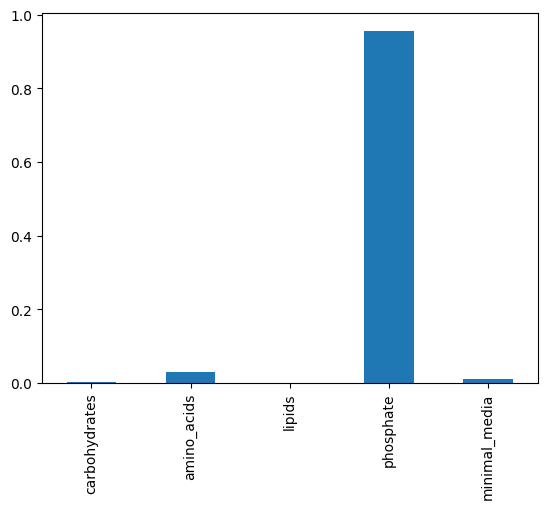

In [52]:
## barplot of percentage values (overall_percentage)
# composition_df['overall_percentage'].plot.bar()



### Is the biomass metabolite helpful in order to understand the biomass composition?

In [21]:
## default flux iYali4_model
iYali4_model.summary() # m511 glucose (10) => 1.37 (growth rate)

# m511 = iYali4_model.metabolites.get_by_id('m511')
# m511.summary() # => glucose

# m1031 = iYali4_model.metabolites.get_by_id('m1031')
# m1031.summary() # => ammonia

# ## check summary of biomass_C reaction
# iYali4_model.reactions.biomass_C.summary()

# m1401 = iYali4_model.metabolites.get_by_id('m1401')
# m1401.summary() # => biomass

# # check exchange and biomass reaction:
# glucose_exchange = iYali4_model.reactions.get_by_id('1714')
# glucose_exchange

# biomass reaction
biomass_reaction = iYali4_model.reactions.get_by_id('biomass_C')
biomass_reaction.summary() # => m1401 biomass

m1401 = iYali4_model.metabolites.get_by_id('m1401')
m1401.summary() # => biomass

Percent,Flux,Reaction,Definition
100.00%,1.378,biomass_C,0.035251 m1000 + 0.172773 m1008 + 0.943397 m1123 + 0.567939 m114 + 0.243866 m130 + 0.235849 m1324 + 23.09 m141 + 0.059363 m149 + 3.5e-05 m1631 + 0.000234 m1640 + 7.5e-05 m1648 + 0.000237 m1700 + 0.000346 m1701 + 5.8e-05 m1705 + 0.186531 m267 + 0.509943 m272 + 0.00686 m294 + 0.125563 m310 + 0.186498 m319 + 23.09 m32 + 0.003029 m359 + 0.868358 m401 + 0.284699 m441 + 0.003632 m443 + 0.010436 m459 + 0.009226 m465 + 0.243904 m50 + 0.010353 m505 + 0.053881 m615 + 0.044232 m74 + 0.090566 m743 + 0.206372 m765 + 0.210543 m770 + 0.002154 m772 + 0.19455 m775 + 0.275005 m793 + 0.082571 m859 + 0.055401 m86 + 0.01007 m89 + 0.050871 m93 + 0.05721 m95 + 0.02 m964 + 0.041282 m992 --> 23.09 m10 + m1401 + 23.09 m143 + 23.09 m35
Percent,Flux,Reaction,Definition
100.00%,-1.378,2111,m1401 -->
